In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold

import mylib as my

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

Part 1: Data Pre-processing
Prepare data for classification models.

In [3]:
# Read file and print header
park_data = pd.read_csv('Park_Acoustic.csv')  
print(park_data.head(5))

        ID  Recording  Status  Gender  Jitter_rel  Jitter_abs  Jitter_RAP  \
0  CONT-01          1       0       1     0.25546    0.000015    0.001467   
1  CONT-01          2       0       1     0.36964    0.000022    0.001932   
2  CONT-01          3       0       1     0.23514    0.000013    0.001353   
3  CONT-02          1       0       0     0.29320    0.000017    0.001105   
4  CONT-02          2       0       0     0.23075    0.000015    0.001073   

   Jitter_PPQ  Shim_loc  Shim_dB  ...    Delta3    Delta4    Delta5    Delta6  \
0    0.001673  0.030256  0.26313  ...  1.407701  1.417218  1.380352  1.420670   
1    0.002245  0.023146  0.20217  ...  1.331232  1.227338  1.213377  1.352739   
2    0.001546  0.019338  0.16710  ...  1.412304  1.324674  1.276088  1.429634   
3    0.001444  0.024716  0.20892  ...  1.501200  1.534170  1.323993  1.496442   
4    0.001404  0.013119  0.11607  ...  1.508468  1.334511  1.610694  1.685021   

     Delta7    Delta8    Delta9   Delta10   Delta1

In [4]:
# Create dataframes with data grouped by individual patient
# Mean values only
park_data = park_data.groupby(['ID']).mean()

In [5]:
# Pop status column
status_col = park_data.pop('Status')
print(status_col)

ID
CONT-01    0.0
CONT-02    0.0
CONT-03    0.0
CONT-04    0.0
CONT-05    0.0
          ... 
PARK-36    1.0
PARK-37    1.0
PARK-38    1.0
PARK-39    1.0
PARK-40    1.0
Name: Status, Length: 80, dtype: float64


In [6]:
# Add status column to end of each dataframe, check position
park_data.insert(park_data.shape[1], "Status", status_col.values, allow_duplicates=True)
print(park_data.head(5))

         Recording  Gender  Jitter_rel  Jitter_abs  Jitter_RAP  Jitter_PPQ  \
ID                                                                           
CONT-01        2.0     1.0    0.286747    0.000016    0.001584    0.001821   
CONT-02        2.0     0.0    0.229613    0.000014    0.000999    0.001347   
CONT-03        2.0     1.0    0.228300    0.000015    0.001361    0.001538   
CONT-04        2.0     1.0    1.138800    0.000089    0.006879    0.006169   
CONT-05        2.0     0.0    0.601363    0.000078    0.002963    0.003630   

         Shim_loc   Shim_dB  Shim_APQ3  Shim_APQ5  ...    Delta4    Delta5  \
ID                                                 ...                       
CONT-01  0.024247  0.210800   0.013841   0.015480  ...  1.323076  1.289939   
CONT-02  0.016167  0.139909   0.008835   0.010288  ...  1.514699  1.436049   
CONT-03  0.018355  0.160563   0.009814   0.012021  ...  1.492976  1.477870   
CONT-04  0.025849  0.227540   0.014722   0.014495  ...  1.44719

In [7]:
# Drop recording column
park_data.drop(['Recording'], axis=1, inplace=True)
print(park_data.head(5))

         Gender  Jitter_rel  Jitter_abs  Jitter_RAP  Jitter_PPQ  Shim_loc  \
ID                                                                          
CONT-01     1.0    0.286747    0.000016    0.001584    0.001821  0.024247   
CONT-02     0.0    0.229613    0.000014    0.000999    0.001347  0.016167   
CONT-03     1.0    0.228300    0.000015    0.001361    0.001538  0.018355   
CONT-04     1.0    1.138800    0.000089    0.006879    0.006169  0.025849   
CONT-05     0.0    0.601363    0.000078    0.002963    0.003630  0.035647   

          Shim_dB  Shim_APQ3  Shim_APQ5  Shi_APQ11  ...    Delta4    Delta5  \
ID                                                  ...                       
CONT-01  0.210800   0.013841   0.015480   0.017249  ...  1.323076  1.289939   
CONT-02  0.139909   0.008835   0.010288   0.012707  ...  1.514699  1.436049   
CONT-03  0.160563   0.009814   0.012021   0.014385  ...  1.492976  1.477870   
CONT-04  0.227540   0.014722   0.014495   0.019822  ...  1.447195

In [8]:
# Function to standardize data
def standardize_arr(arr):
    scaler = StandardScaler()
    temp1 = arr[:,0:1]
    temp2 = scaler.fit_transform(arr[:,1:])
    std_arr = np.concatenate((temp1, temp2), axis=1)
    return std_arr

In [9]:
# Use mylib.from_dataframe to produce arrays
X, y, features, targets = my.from_dataframe(park_data, ntargets=1)

In [10]:
# Standardize data
X = standardize_arr(X)

In [11]:
# Split data 80/20
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=.20, random_state=17)

Part 2: Neural Net Setup

In [12]:
# Convert types to match 
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [13]:
# Convert arrays to tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [14]:
# Reshape y
y = y.unsqueeze(1)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [109]:
# Define NN model
park_nn = nn.Sequential(
    nn.Linear(45, 24),
    nn.ReLU(),
    nn.Linear(24, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

# Print model summary
summary(park_nn)

In [112]:
# Loss function and optimizer for binary classfication
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(park_nn.parameters(), lr = 0.01) 

In [119]:
# Training
epochs = 2000
losses = []
for i in range(1, epochs + 1):
    y_hat = park_nn(X_train)
    loss = loss_fn(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    losses.append(loss.item())
    if i == 1 or i % 100 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 0.1288
Epoch   50: loss = 0.1191
Epoch  100: loss = 0.1099
Epoch  150: loss = 0.1011
Epoch  200: loss = 0.0928
Epoch  250: loss = 0.0847
Epoch  300: loss = 0.0770
Epoch  350: loss = 0.0688
Epoch  400: loss = 0.0618
Epoch  450: loss = 0.0556
Epoch  500: loss = 0.0501
Epoch  550: loss = 0.0454
Epoch  600: loss = 0.0412
Epoch  650: loss = 0.0375
Epoch  700: loss = 0.0342
Epoch  750: loss = 0.0313
Epoch  800: loss = 0.0287
Epoch  850: loss = 0.0265
Epoch  900: loss = 0.0244
Epoch  950: loss = 0.0226
Epoch  1000: loss = 0.0210
Epoch  1050: loss = 0.0196
Epoch  1100: loss = 0.0183
Epoch  1150: loss = 0.0171
Epoch  1200: loss = 0.0161
Epoch  1250: loss = 0.0151
Epoch  1300: loss = 0.0142
Epoch  1350: loss = 0.0134
Epoch  1400: loss = 0.0127
Epoch  1450: loss = 0.0120
Epoch  1500: loss = 0.0114
Epoch  1550: loss = 0.0108
Epoch  1600: loss = 0.0103
Epoch  1650: loss = 0.0098
Epoch  1700: loss = 0.0093
Epoch  1750: loss = 0.0089
Epoch  1800: loss = 0.0085
Epoch  1850: loss = 0

In [120]:
# Generate predictions for training data
model_preds = park_nn(X)

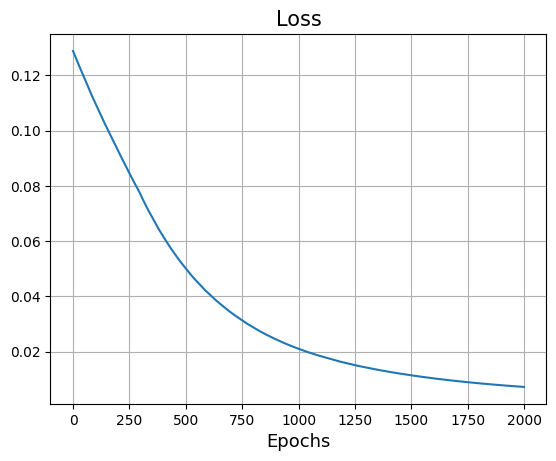

In [130]:
# Plot losses
plt.plot(losses)
plt.title('Loss', size=15)
plt.xlabel('Epochs', size=13)
plt.grid()

In [138]:
# Generate predictions for test data, test accuracy
nn_preds = torch.where(park_nn(X_test).detach() > .5, 1 , 0)
print(f'Neural Net Accuracy Score: {accuracy_score(y_test, nn_preds)}')

Neural Net Accuracy Score: 0.875


K-Fold Cross Validation

In [157]:
# Testing Kfold
# Set up K-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = torch.cat(torch.tensor_split(X, tuple(train_index), dim=1), dim=1), torch.cat(torch.tensor_split(X, tuple(val_index), dim=1), dim=1)
    y_train_fold, y_val_fold = torch.cat(torch.tensor_split(y, tuple(train_index), dim=1), dim=1), torch.cat(torch.tensor_split(y, tuple(val_index), dim=1), dim=1)
    print(X_train_fold.shape)
    print(X_val_fold.shape)


torch.Size([64, 45])
torch.Size([64, 45])
torch.Size([64, 45])
torch.Size([64, 45])
torch.Size([64, 45])


In [16]:
from sklearn.model_selection import KFold

# Set up K-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# List to store accuracy for each fold
accuracy_per_fold = []

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = torch.cat(torch.tensor_split(X, tuple(train_index), dim=1), dim=1), torch.cat(torch.tensor_split(X, tuple(val_index), dim=1), dim=1)
    y_train_fold, y_val_fold = torch.cat(torch.tensor_split(y, tuple(train_index), dim=1), dim=1), torch.cat(torch.tensor_split(y, tuple(val_index), dim=1), dim=1)
    
    # Create a new instance of the model for each fold
    park_nn = nn.Sequential(
        nn.Linear(45, 24),
        nn.ReLU(),
        nn.Linear(24, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Sigmoid()
    )    

    # Loss function and optimizer for binary classfication
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(park_nn.parameters(), lr = 0.01) 

    # Train the model on the training fold
    epochs = 2000
    for i in range(1, epochs + 1):
        y_hat = park_nn(X_train_fold)
        loss = loss_fn(y_hat, y_train_fold)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    
    # Evaluate the model on the validation fold
    val_predictions = torch.where(park_nn(X_val_fold).detach() > .5, 1 , 0)
    accuracy = accuracy_score(y_val_fold, val_predictions)
    
    # Store the accuracy for this fold
    accuracy_per_fold.append(accuracy)
    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracy_per_fold)
print(f'\nAverage Accuracy Across {k} Folds: {average_accuracy * 100:.2f}%')

Accuracy for fold 1: 90.00%
Accuracy for fold 2: 91.25%
Accuracy for fold 3: 92.50%
Accuracy for fold 4: 92.50%
Accuracy for fold 5: 92.50%

Average Accuracy Across 5 Folds: 91.75%
